In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/processed.anndata.lt.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

# some simple filtering
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=100)

# compute HVG
sc.pp.highly_variable_genes(adata)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.67 GB, difference +8.67 GB
Memory usage: current 8.69 GB, difference +0.02 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'go_annotations', 'log1p', 'panglaodb', 'hvg'
    layers: 'log_norm', 'raw_counts'

In [3]:
# break

In [4]:
adata.obs['dataset'].value_counts()

dataset
tabula_sapiens    26586
pellin            12228
iHSC               8574
young2_HSC         3703
old2_BMMC_HSPC     2365
old1_BMMC_HSPC      891
Name: count, dtype: int64

In [5]:
adata.obs['cell_type'].value_counts()

cell_type
FB                        26586
iHSC                       8574
LinNegCD34PosCD164Pos      6343
HSC                        5798
LinNegCD34lowCD164high     4265
MPP                        1795
MKP                         863
MLP                         123
Name: count, dtype: int64

In [6]:
adata.obs['organ_tissue'].value_counts()

organ_tissue
nan                27761
Fat                 8459
Vasculature         5867
Bladder             5557
Thymus              3924
Trachea             1239
Large_Intestine      953
Tongue               251
Prostate             223
Small_Intestine      113
Name: count, dtype: int64

# Add gene sets

In [7]:
cell_types = {
    "B_mem": "B cells memory",
    "B_naive": "B cells naive",
    "Baso": "Basophils",
    "DC": "Dendritic cells",
    "Endo": "Endothelial cells",
    "Eos": "Eosinophils",
    "Ery": "Erythroblasts",
    "Fibro": "Fibroblasts",
    "HSC": "Hematopoietic stem cells",
    "Macro": "Macrophages",
    "Mega": "Megakaryocytes",
    "Mono": "Monocytes",
    "MDSC": "Myeloid-derived suppressor cells",
    "Neut": "Neutrophils",
    "Osteo": "Osteoblasts",
    "Plasma": "Plasma cells",
    "pDC": "Plasmacytoid dendritic cells",
    "Retic": "Reticulocytes",
    "Stromal": "Stromal cells"
}

pang = adata.uns['panglaodb'].copy()

for k, v in cell_types.items():
    
    genes = pang[pang['cell_type'] == v]['gene_name'].values
    adata.var[k] = adata.var['gene_name'].isin(genes)
    
    exp_genes = adata.var[adata.var[k]]['gene_name']
    print(f"{v} ({k}): {len(exp_genes)} genes")

    
# add the flag to the var dataframe
adata.var['cluster_genes'] = adata.var[list(cell_types.keys())].any(axis=1)
adata.var['cluster_genes'].value_counts()

B cells memory (B_mem): 60 genes
B cells naive (B_naive): 63 genes
Basophils (Baso): 71 genes
Dendritic cells (DC): 118 genes
Endothelial cells (Endo): 184 genes
Eosinophils (Eos): 27 genes
Erythroblasts (Ery): 26 genes
Fibroblasts (Fibro): 167 genes
Hematopoietic stem cells (HSC): 88 genes
Macrophages (Macro): 127 genes
Megakaryocytes (Mega): 47 genes
Monocytes (Mono): 99 genes
Myeloid-derived suppressor cells (MDSC): 15 genes
Neutrophils (Neut): 69 genes
Osteoblasts (Osteo): 62 genes
Plasma cells (Plasma): 64 genes
Plasmacytoid dendritic cells (pDC): 54 genes
Reticulocytes (Retic): 8 genes
Stromal cells (Stromal): 35 genes


cluster_genes
False    18068
True      1002
Name: count, dtype: int64

# PCA

Performing PCA dimensionality reduction...


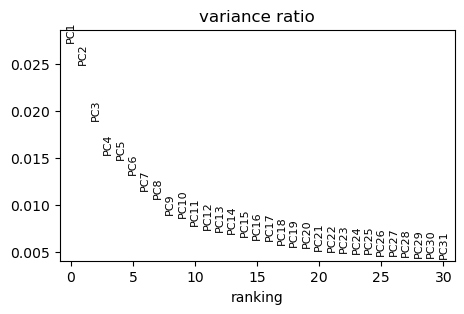

In [8]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    adata, 
    n_comps=50, 
    mask_var='cluster_genes',
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    adata, 
)

# Reclustering

Calculating nearest neighbors...
Computing UMAP embedding...
Running Leiden clustering algorithm...


/tmp/ipykernel_1253328/4222372973.py:19: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(



Cluster distribution:
new_cluster
0     7630
1     6686
2     6298
3     5274
4     4496
5     4481
6     3001
7     2795
8     2729
9     2580
10    1546
11    1318
12    1199
13    1007
14     873
15     725
16     704
17     445
18     318
19     190
20      52
Name: count, dtype: int64


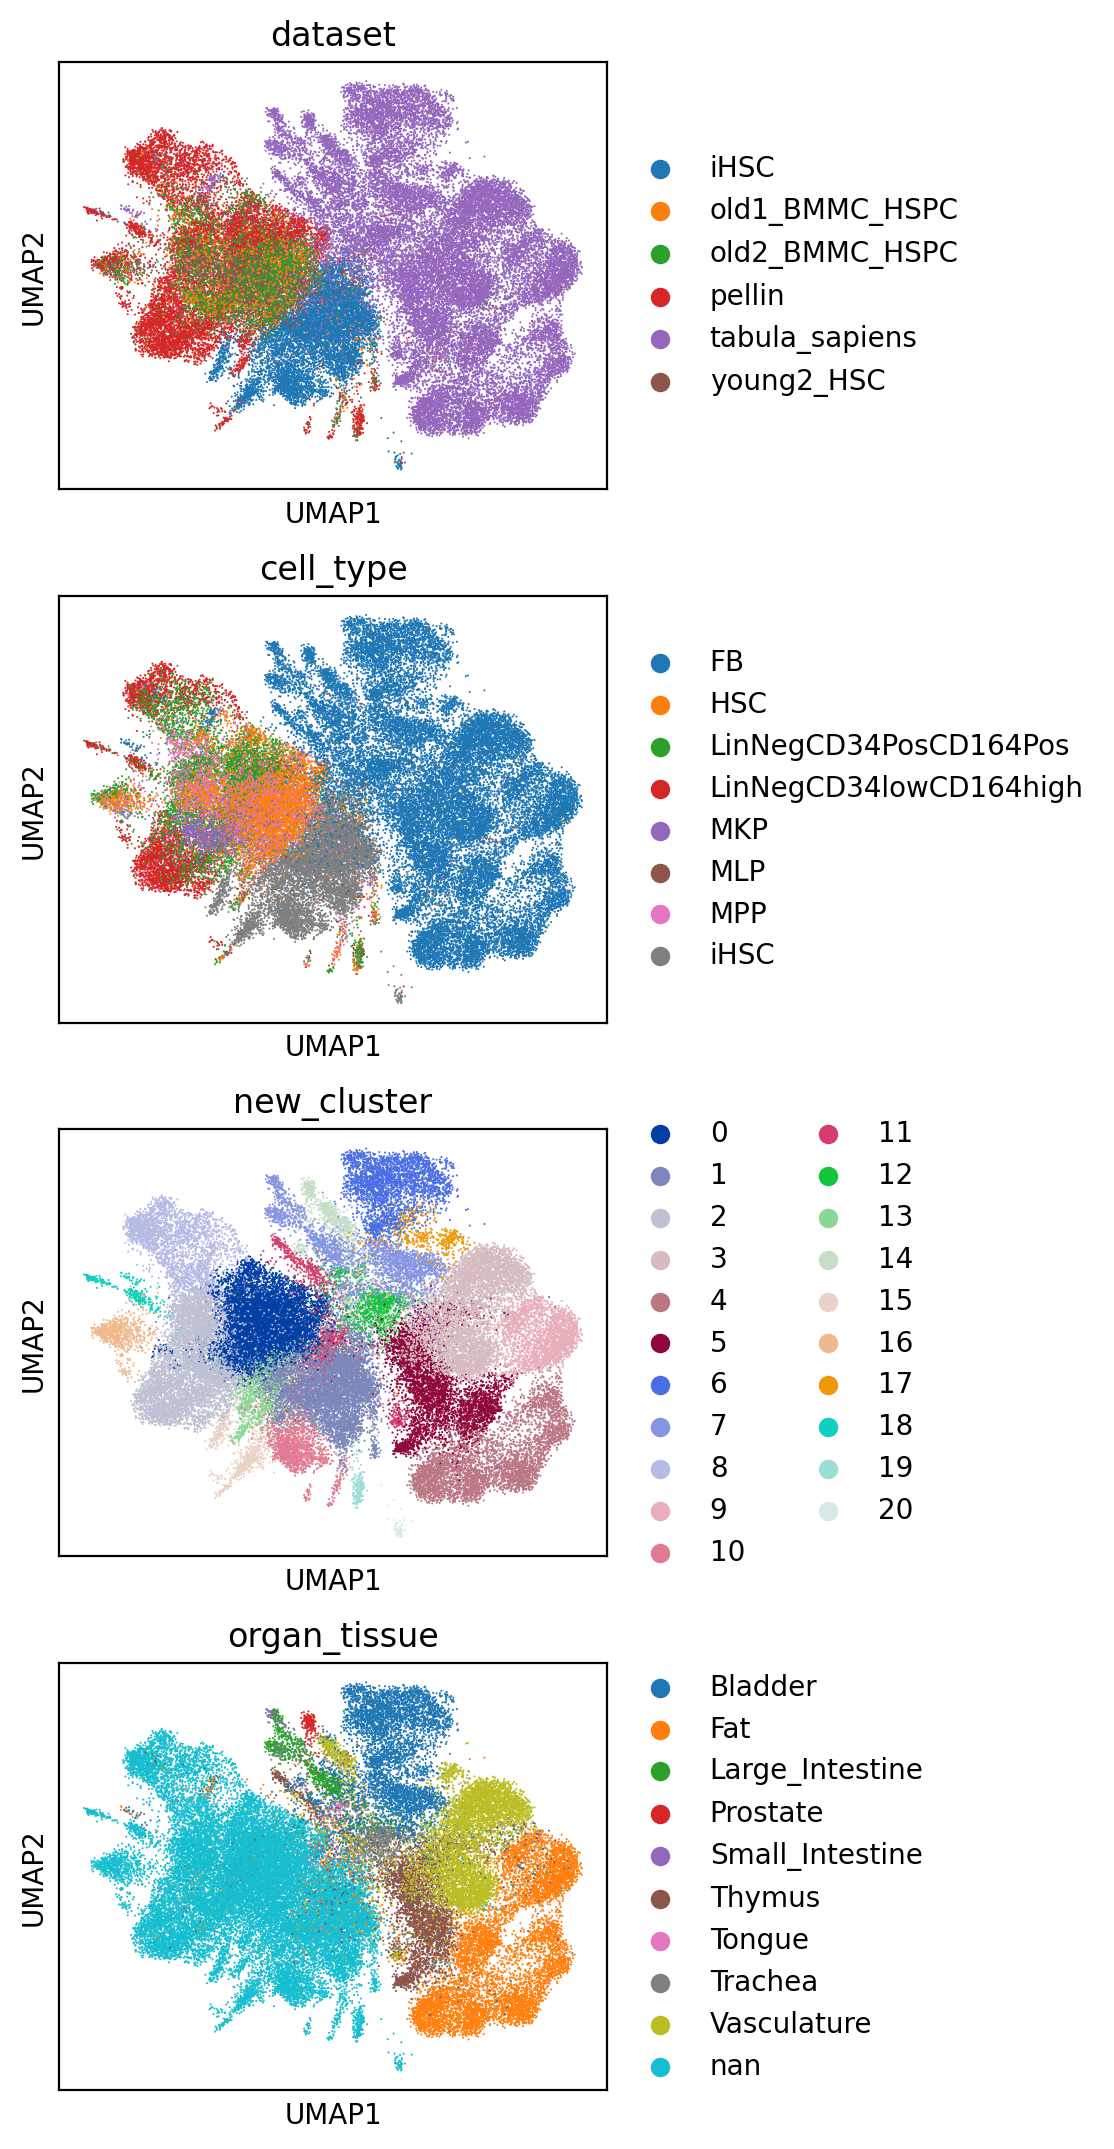

In [9]:
# Calculate Nearest Neighbors
print("Calculating nearest neighbors...")
sc.pp.neighbors(
    adata,
    n_pcs=50, # approximate effective rank from above
    n_neighbors=100,
)

# UMAP Embedding
print("Computing UMAP embedding...")
sc.tl.umap(
    adata,
    min_dist=0.75,
    # spread=1.5,
)

# Leiden Clustering
print("Running Leiden clustering algorithm...")
sc.tl.leiden(
    adata, 
    resolution=0.65, 
    directed=True,
    key_added='new_cluster',
)

# Optionally, you can add a print statement to inspect the clusters:
print("\nCluster distribution:")
print(adata.obs['new_cluster'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
# Plot it!
sc.pl.umap(
    adata,
    color=['dataset','cell_type','new_cluster', 'organ_tissue'],
    ncols=1,
)

In [10]:
"""
Add some nice labels
"""

cell_map = {
    'iHSC' : 'Reprogrammed Cells', 
    'LinNegCD34lowCD164high' : 'Lineage Negative (CD34low/CD164high)', 
    'HSC' : 'Hematopoietic Stem Cell',
    'LinNegCD34PosCD164Pos' : 'Lineage Negative (CD34Pos/CD164Pos)',
    'MPP' : 'Multipotent Progenitor', 
    'MLP' : 'Multi-Lymphoid Progenitor',
    'FB' : 'Fibroblast',
    'MKP' : 'Megakaryocyte-Erythroid Progenitor',
}

adata.obs['cell_label'] = adata.obs['cell_type'].map(cell_map)
adata.obs['cluster_str'] = adata.obs['new_cluster'].apply(lambda x: "D" + str(int(x) + 1))
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

outpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"
adata.write(outpath)

adata

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'go_annotations', 'log1p', 'panglaodb', 'hvg', 'pca', 'neighbors', 'umap', 'new_cluster', 'dataset_colors', 'cell_type_colors', 'new_cluster_colors', 'organ_tissue_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'distances', 'connectivities'

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, 
                       color='GFI1B', 
                       title='GFI1B',
                       vmin=0,
                       vmax=2, 
                       s=3)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, 
                       color='KLF1', 
                       title='KLF1',
                       vmin=0,
                       vmax=2, 
                       s=3)

# Distances

In [ ]:
metric = 'euclidean'
n_comps = 15
X = adata.obsm['X_pca'][:, 0:n_comps]

def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

D = scipy.spatial.distance.pdist(X, metric=metric) 
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=adata.obs.index, columns=adata.obs.index)
print(f"{D.shape=}")
D.head()

In [ ]:
def calculate_mean_group_distances(D, pdf, group_col='group'):
    """Calculates mean pairwise distances between groups in a distance matrix.

    Args:
        D (pd.DataFrame): Pairwise distance matrix with index and columns matching pdf.obs.index.
        pdf (anndata.AnnData): Annotated data object containing the grouping column.
        group_col (str, optional): The column name in `pdf.obs` specifying the groups (default is 'group').

    Returns:
        pd.DataFrame: A pivot table with mean pairwise distances between groups.
    """
    results = []
    
    for i_name, group_i in pdf.obs.groupby(group_col):
        for j_name, group_j in pdf.obs.groupby(group_col):
            i_idx = group_i.index
            j_idx = group_j.index
        
            mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())
        
            row = {
                'i_name' : i_name,
                'j_name' : j_name,
                'mean_dist' : mean_dist,
            }
        
            results.append(row)
            
    results = pd.DataFrame(results)
    results = pd.pivot_table(results, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')
    return results


means = calculate_mean_group_distances(D, adata, group_col='biotype')
means.head()

In [ ]:
cmap = 'coolwarm'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(means, 
            square=True,
            linewidth=0.5,
            annot=True,
            cmap=cmap,
            fmt=".2f",
            # vmin=0,
            # vmax=1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

In [ ]:
break

In [ ]:
sc.tl.paga(adata, groups="biotype")
sc.pl.paga(adata, color=["biotype"])
sc.tl.umap(adata, init_pos='paga', min_dist=0.1, spread=5.0)

sc.pl.umap(adata, 
           color=['dataset','cell_type'],
           ncols=1,
           s=30,)

In [ ]:
(0.22) --- (-0.23) --- (0.33) --- (-0.12)

In [ ]:
break

# Reprocess

In [ ]:
# # batch correction
# sc.pp.combat(adata, key='dataset')
# adata.X = np.where(adata.X < 0, 0, adata.X)

sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.tl.pca(adata, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=51)
sc.tl.umap(adata, min_dist=0.25)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(adata, 
           color=['dataset','cell_type'],
           ncols=1,
           s=30,)

In [ ]:
# break

In [ ]:
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

cell_map = {
    'iHSC' : 'iHSC',
    'PreBNK' : 'PreBNK',
    'LinNegCD34lowCD164high' : 'LinNeg',
    'HSC' : 'HSC',
    'CMP' : 'CMP',
    'MEP' : 'MEP',
    'LinNegCD34PosCD164Pos' : 'LinNeg',
    'LinNegCD34NegCD164high' : 'LinNeg',
    'MPP' : "MPP",
    'GMP' : "GMP",
    'LinNegCD34NegCD164low' : 'LinNeg',
    'MLP' : "MLP",
    'FB' : "Fibroblast",
    'MKP' : "MKP"
}

adata.obs['broad_type'] = adata.obs['cell_type'].map(cell_map)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='none',
                lw=0.1,
                alpha=0.9,
                hue='broad_type',
                palette="nipy_spectral",
                s=5)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Cell Type",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.4, 1.017))

plt.gca().set_aspect('auto')

In [ ]:
sc.tl.paga(adata, groups="broad_type")
sc.pl.paga(adata, color=["broad_type"])
sc.tl.umap(adata, init_pos='paga', min_dist=0.1, spread=5.0)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(adata, 
           color='broad_type',
           ncols=1,
           s=30,)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5


sc.pl.umap(adata, 
           color='broad_type',
           palette='turbo',
           s=10,
           title="",
           add_outline=True)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

data_map = {
    'iHSC' : 'iHSC 2024', 
    'pellin' : 'Pellin 2019', 
    'tabula_sapiens' : 'Tabula Sapiens 2023',
    'young2_HSC' : 'Weng 2024',
}

adata.obs['Data Source'] = adata.obs['dataset'].map(data_map)

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                lw=0.1,
                alpha=0.9,
                hue='Data Source',
                palette="hsv",
                s=3)


plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Data Source",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.6, 1.017))

plt.gca().set_aspect('auto')

In [ ]:
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                ec='None',
                zorder=0,
                color='lightgrey',
                legend=False,
                s=5)


mask = adata.obs['cell_type'].isin(["HSC", "iHSC", 'FB'])
to_plot = adata.obs[mask].reset_index(drop=False).copy()
to_plot['cell_type'] = to_plot['cell_type'].astype(str)
to_plot['broad_type'] = to_plot['broad_type'].astype(str)

sns.scatterplot(data=to_plot,
                x='UMAP 1',
                y='UMAP 2',
                ec='k',
                zorder=2,
                hue='broad_type',
                palette=['purple', "blue", "red"],
                s=5)

plt.xticks([])
plt.yticks([])

sns.move_legend(plt.gca(), 
                title="Cell Type",
                loc='upper right',
                markerscale=3,
                bbox_to_anchor=(1.6, 1))

plt.gca().set_aspect('auto')

In [ ]:
# break

# Gene Expression

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, 
                       color='CD34',
                       vmin=1, 
                       vmax=5,
                       title='CD34', 
                       s=3,
                      )


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, 
                       color='GATA2', 
                       title='GATA2',
                       vmin=0, 
                       vmax=4,
                       s=3)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, 
                       color='GFI1B', 
                       title='GFI1B',
                       vmin=0,
                       vmax=2, 
                       s=3)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
plt2.plot_umap_scatter(adata, color='KLF1', title='KLF1', vmin=0, vmax=3, s=3)

In [ ]:
break

# Plot Basins

In [ ]:
iHSC = pdf[pdf.obs['broad_type'] == 'iHSC', :]
HSC = pdf[pdf.obs['broad_type'] == 'HSC', :]
FB = pdf[pdf.obs['broad_type'] == 'Fibroblast', :]

In [ ]:
reload(plt2)
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7
plt2.plot_basin(HSC.obs, cmap='Greens')
plt2.plot_basin(FB.obs, cmap='Blues')
sns.scatterplot(data=iHSC.obs, 
               x='UMAP 1',
               y='UMAP 2',
               c='r',
               ec='none',
               s=3,
               )
plt.xticks([])
plt.yticks([])

# Distance

In [ ]:
metric = 'euclidean'
n_comps = 15
X = pdf.obsm['X_pca'][:, 0:n_comps]

def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

D = scipy.spatial.distance.pdist(X, metric=metric) 
# D = min_max(D)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, columns=pdf.obs.index)
print(f"{D.shape=}")
D.head()

In [ ]:
def calculate_mean_group_distances(D, pdf, group_col='group'):
    """Calculates mean pairwise distances between groups in a distance matrix.

    Args:
        D (pd.DataFrame): Pairwise distance matrix with index and columns matching pdf.obs.index.
        pdf (anndata.AnnData): Annotated data object containing the grouping column.
        group_col (str, optional): The column name in `pdf.obs` specifying the groups (default is 'group').

    Returns:
        pd.DataFrame: A pivot table with mean pairwise distances between groups.
    """
    results = []
    
    for i_name, group_i in pdf.obs.groupby(group_col):
        for j_name, group_j in pdf.obs.groupby(group_col):
            i_idx = group_i.index
            j_idx = group_j.index
        
            mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())
        
            row = {
                'i_name' : i_name,
                'j_name' : j_name,
                'mean_dist' : mean_dist,
            }
        
            results.append(row)
            
    results = pd.DataFrame(results)
    results = pd.pivot_table(results, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')
    return results


means = calculate_mean_group_distances(D, pdf, group_col='broad_type')
means.head()

In [ ]:
cmap = 'coolwarm'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.heatmap(means, 
            square=True,
            linewidth=0.5,
            # annot=True,
            cmap=cmap,
            # fmt=".2f",
            # vmin=0,
            # vmax=1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

# distribution of distances for HSC/FIB from iHSC

In [ ]:
ihsc_ind = pdf.obs[pdf.obs['cell_type'] == "iHSC"].index
hsc_ind = pdf.obs[pdf.obs['cell_type'] == "HSC"].index
fb_ind = pdf.obs[pdf.obs['cell_type'] == "FB"].index

print(f"{len(ihsc_ind)=} {len(hsc_ind)=} {len(fb_ind)=}")

t = pd.DataFrame({
    'mean_distance_fb' : D.loc[ihsc_ind][fb_ind].mean(axis=1),   
    'mean_distance_hsc' : D.loc[ihsc_ind][ihsc_ind].mean(axis=1),   
})

print(f"{t.shape=}")
outpath = "/nfs/turbo/umms-indikar/shared/projects/R01/iHSC_euclidean_distance_15pcs.csv"
t = t.reset_index()
t.to_csv(outpath, index=False)
t.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.25, 2

sns.boxplot(data=pd.melt(t, id_vars='index'), 
            x='variable',
            y='value',
            showfliers=False,
           )

plt.gca().tick_params(axis='x', rotation=90)
ticks = plt.xticks() 
plt.xticks(ticks[0], ['Firboblast', "HSC"])
plt.xlabel("")
plt.ylabel("Euclidean Distance")

In [ ]:
t = pd.DataFrame({
 'distance' : np.diag(means),   
 'cell_type' : means.index,
})

t = t.sort_values(by='distance', ascending=False)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2
sns.barplot(data=t, 
            x='cell_type',
            y='distance',
            ec='k'
           )

plt.ylabel('Cell-Cell Distance')
plt.xlabel('')
plt.gca().tick_params(axis='x', rotation=90)

In [ ]:
pdf.obs['Data Source'].unique()

In [ ]:
pdf.obs[pdf.obs['Data Source'] == 'Tabula Sapiens 2023']['cell_type'].unique()

# Gene Scores

In [ ]:
score_name = 'HSC Markers'
genes = [
    'GATA2', 
    'PTPRC',
    "CD34",
    "CD164", 
    'GFI1B', 
]

gene_ids = pdf.var[pdf.var['gene_name'].isin(genes)].index

sc.tl.score_genes(pdf,
                  gene_list=gene_ids, 
                  ctrl_size=len(gene_ids),
                  score_name=score_name)

pdf.obs[score_name] = pdf.obs[score_name]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

plt2.plot_umap_scatter(pdf, 
                      s=5, 
                      cmap='coolwarm',
                      title='HSC Genes',
                      vmin=-1,
                      vmax=1,
                      color=score_name)

In [ ]:
break

In [ ]:
iHSC = pdf[pdf.obs['broad_type'] == 'iHSC', :]
HSC = pdf[pdf.obs['broad_type'] == 'HSC', :]
FB = pdf[pdf.obs['broad_type'] == 'Fibroblast', :]

print(f"{iHSC.obsm['X_pca'].shape=} {HSC.obsm['X_pca'].shape=} {FB.obsm['X_pca'].shape=}")

In [ ]:
metric = 'euclidean'

D2FB = scipy.spatial.distance.cdist(iHSC.obsm['X_pca'], 
                                    FB.obsm['X_pca'], 
                                    metric=metric
                                   )

D2HSC = scipy.spatial.distance.cdist(iHSC.obsm['X_pca'],
                                     HSC.obsm['X_pca'], 
                                     metric=metric
                                    )

print(f"{D2FB.shape=}")
print(f"{D2HSC.shape=}")

dist = pd.DataFrame({
    'distance_2_fb' :  D2FB.mean(axis=1),
    'distance_2_hsc' : D2HSC.mean(axis=1),
})


dist.index = iHSC.obs.index

dist.head()

In [ ]:
def calculate_relative_position(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculates the relative position of values in two vectors on a scale of -1 to 1.

    Args:
        x: A numpy array with values between 0 and -n.
        y: A numpy array with values between 0 and m.

    Returns:
        A numpy array of relative positions between -1 and 1.
    """

    # Ensure vectors are of the same length
    if len(x) != len(y):
        raise ValueError("Input vectors must have the same length.")

    # Normalize x and y to the range [-1, 1]
    x_normalized = x / abs(x.min())  
    y_normalized = y / y.max()

    # Calculate relative positions
    relative_positions = (x_normalized + y_normalized) / 2

    return relative_positions

def continuum(df: pd.DataFrame, dist_col1: str, dist_col2: str, decay_factor: float = 1.0) -> pd.Series:
    """Plots cells along a continuum based on exponential decay of two distance columns.

    Args:
        df: A DataFrame containing the distance columns.
        dist_col1: The name of the first distance column.
        dist_col2: The name of the second distance column.
        decay_factor: The factor controlling the exponential decay rate.

    Returns:
        A Series with the cell_id as index and the continuum position as values.
    """
    # Exponential decay calculation
    x = np.exp(-decay_factor * df[dist_col1])
    y = np.exp(-decay_factor * df[dist_col2])

    # Calculate continuum positions
    continuum_positions = calculate_relative_position(x, y)
    continuum_positions = pd.Series(continuum_positions, index=df.index)
    return continuum_positions.sort_values()
    
    
cont = continuum(dist, 
                 dist_col1='distance_2_fb', 
                 dist_col2='distance_2_hsc')   

cont.max()
# sns.histplot(cont)

In [ ]:
break

In [ ]:
dist.columns

# Plot the basins

In [ ]:
def plot_basin(df, x='UMAP 1', y='UMAP 2', cmap="Reds", bins=100, pthresh=.1, levels=4):
    """
    Plots a basin based on UMAP dimensionality reduction, combining scatter, 2D histogram, and density contours with automatic color selection.

    Args:
        df (pandas.DataFrame): The dataframe containing the UMAP coordinates.
        x (str): The column name for the x-axis ('UMAP 1' by default).
        y (str): The column name for the y-axis ('UMAP 2' by default).
        cmap (str): The colormap for the 2D histogram ("Reds" by default).
        bins (int): The number of bins for the 2D histogram (100 by default).
        pthresh (float): The percentile threshold for the 2D histogram (0.1 by default).
        levels (int): The number of contour levels for the density plot (4 by default).
    """

    # 2D Histogram: Shows density distribution
    sns.histplot(data=df, x=x, y=y, bins=bins, pthresh=pthresh, cmap=cmap)

    # Determine Color for Contours based on colormap
    cmap_obj = plt.cm.get_cmap(cmap)  # Get the colormap object
    contour_color = cmap_obj(0.8)  # Choose a color towards the end of the colormap
    
    # 3. Density Contours: Smoothly outlines areas of high density
    sns.kdeplot(data=df, x=x, y=y, levels=levels, color=contour_color, linewidths=0.5)
    
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7
plot_basin(HSC.obs, cmap='Greens')
plot_basin(FB.obs, cmap='Blues')
sns.scatterplot(data=iHSC.obs, 
               x='UMAP 1',
               y='UMAP 2',
               c='r',
               ec='none',
               s=0.25,
               )
plt.xticks([])
plt.yticks([])

In [ ]:
def plot_density_basin(df, x='UMAP 1', y='UMAP 2', cmap="Reds", bins=500, pthresh=.1, alpha_max=0.8):
    """
    Plots a basin based on UMAP dimensionality reduction, combining scatter, 2D histogram, and fading density representation.

    Args:
        df (pandas.DataFrame): The dataframe containing the UMAP coordinates.
        x (str): The column name for the x-axis ('UMAP 1' by default).
        y (str): The column name for the y-axis ('UMAP 2' by default).
        cmap (str): The colormap for the 2D histogram ("Reds" by default).
        bins (int): The number of bins for the 2D histogram (100 by default).
        pthresh (float): The percentile threshold for the 2D histogram (0.1 by default).
        alpha_max (float): The maximum alpha value for the density plot (0.8 by default).
    """
    #Calculate density
    x_values = df[x]
    y_values = df[y]
    xx, yy = np.mgrid[x_values.min():x_values.max():100j, y_values.min():y_values.max():100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x_values, y_values])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # 2D Histogram: Shows density distribution
    sns.histplot(data=df, x=x, y=y, bins=bins, pthresh=pthresh, cmap=cmap)

    # Fading Density Representation:
    plt.imshow(np.rot90(f), 
               cmap=cmap, 
               alpha=alpha_max, 
               extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()])
    
    
plot_density_basin(HSC.obs)
plot_density_basin(FB.obs, cmap='Blues')

In [ ]:
break

# Pseudotime

In [ ]:
mask = (pdf.obs['cell_type'] != 'FB')
hdf = pdf[mask, :].copy()

sc.pp.combat(hdf, key='dataset')

# handle negatives
hdf.X = np.where(hdf.X < 0, 0, hdf.X)

# reprocess
sc.pp.highly_variable_genes(hdf, n_top_genes=2000)

sc.tl.pca(hdf)
sc.pp.neighbors(hdf)
sc.tl.umap(hdf) 

hdf

In [ ]:
sc.pl.umap(hdf,
           color=['cell_type', 'dataset'],
           s=50)

In [ ]:
root_type = "HSC"
hdf.uns['iroot'] = np.flatnonzero(hdf.obs['cell_type'] == root_type)[0]

sc.tl.diffmap(hdf, n_comps=21)
sc.pp.neighbors(hdf, n_neighbors=7)
sc.tl.dpt(hdf, n_branchings=0)

hdf

In [ ]:
sc.pl.umap(hdf,
           color='dpt_pseudotime',
           vmin=0, 
           vmax=0.5,
           s=50)

In [ ]:
break

In [ ]:
break